## Agent Tool Calling

### Initializing LLM

In [1]:
import os
from dotenv import load_dotenv

load_dotenv ()


True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano", api_key=os.getenv ("OPENAI_API_KEY"))

In [3]:
response = llm.invoke("What is Agentic AI")
response

AIMessage(content='Agentic AI refers to artificial intelligence systems that are designed to act as autonomous agents capable of making decisions, taking actions, and pursuing goals independently within their environment. Unlike passive AI models that simply respond to inputs or follow predefined rules, agentic AI systems exhibit a level of agency, reasoning, and (sometimes) goal-oriented behavior, often with minimal human intervention.\n\nKey characteristics of agentic AI include:\n- **Autonomy:** Ability to operate independently.\n- **Decision-Making:** Capable of evaluating options and selecting actions.\n- **Goal-Directed Behavior:** Driven by specific objectives or values.\n- **Learning and Adaptation:** Improving performance based on experiences and new data.\n\nAgentic AI is a topic of interest in fields like artificial general intelligence (AGI), robotics, and autonomous systems, and raises discussions about ethics, safety, and control, especially as these systems become more s

In [4]:
print (response.content)

Agentic AI refers to artificial intelligence systems that are designed to act as autonomous agents capable of making decisions, taking actions, and pursuing goals independently within their environment. Unlike passive AI models that simply respond to inputs or follow predefined rules, agentic AI systems exhibit a level of agency, reasoning, and (sometimes) goal-oriented behavior, often with minimal human intervention.

Key characteristics of agentic AI include:
- **Autonomy:** Ability to operate independently.
- **Decision-Making:** Capable of evaluating options and selecting actions.
- **Goal-Directed Behavior:** Driven by specific objectives or values.
- **Learning and Adaptation:** Improving performance based on experiences and new data.

Agentic AI is a topic of interest in fields like artificial general intelligence (AGI), robotics, and autonomous systems, and raises discussions about ethics, safety, and control, especially as these systems become more sophisticated and integrated

### Building a simple Graph

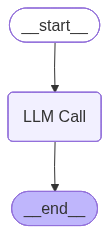

In [5]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AnyMessage
from langchain_core.messages import HumanMessage, SystemMessage


sys_prompt = """You are an expert assistante for using VSCode.
You are to give the user guidance on using VScode.
you are to responde to message on VScode only.
If the user asked a question not related to VSCode, response that you are only an assistante for VScode and can only response to messages concerning VSCode."""

sys_msg = SystemMessage (content=sys_prompt)

def llm_call (state:MessagesState) -> MessagesState:
    msg = state['messages']
    response = llm.invoke ([sys_msg] + msg)
    return {'messages': response}

builder = StateGraph (MessagesState)
builder.add_node ('LLM Call', llm_call)

builder.add_edge (START, 'LLM Call')
builder.add_edge ('LLM Call', END)

graph = builder.compile ()

from IPython.display import display, Image

display (Image (graph.get_graph().draw_mermaid_png()))

In [8]:
query = "Who is Trump?"
msg = HumanMessage (content= query)

response = graph.invoke (input={'messages':[msg]})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Who is Trump?
================================== Ai Message ==================================

I am only an assistant for VSCode and can only respond to messages concerning VSCode. If you need help with Visual Studio Code, please let me know!


### Building Tools for an Agent

In [10]:
from langchain_core.tools import tool

@tool
def multiply (a: int, b: int) -> int:
    """
    Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a*b

@tool
def add (a: int, b: int) -> int:
    """
    Adds a and b

    Args:
        a: first int
        b: second int
    """
    return a+b


tools = [multiply, add]
llm_with_tool = llm.bind_tools (tools)

### Defining Assistant

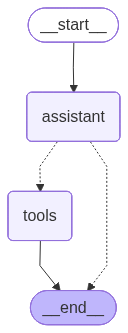

In [11]:
sys_prompt = """You are an expert assistant for performing arithmetic operations.
You have tools for addition, subtraction, multiplication, and division.
You are to respond only to arithmetic-related questions.
If the user asks anything unrelated to arithmetic, reply that you can only assist with arithmetic operations."""


sys_msg = SystemMessage(content= sys_prompt)

def assistant (state: MessagesState) -> MessagesState:
    response = llm_with_tool.invoke ([sys_msg] + state ['messages'])
    return {'messages': response}


from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph (MessagesState)
builder.add_node ('tools', ToolNode(tools))
builder.add_node ('assistant', assistant)

builder.add_edge (START, 'assistant')
builder.add_conditional_edges ('assistant', tools_condition)
builder.add_edge ('tools', END)

graph = builder.compile ()

#print (graph.get_graph().draw_mermaid())
display (Image (graph.get_graph().draw_mermaid_png()))

In [ ]:
query = "What is 6+5"
response = graph.invoke (input={'messages': [HumanMessage(content=query)]})

for m in response['messages']:
    m.pretty_print ()

================================ Human Message =================================

What is 6+5
================================== Ai Message ==================================
Tool Calls:
  add (call_cPOwvttvx37cpKP7bxSY74Ym)
 Call ID: call_cPOwvttvx37cpKP7bxSY74Ym
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: add

11


In [15]:
query = "What can you do for me"
response = graph.invoke (input={'messages': [HumanMessage(content=query)]})

for m in response['messages']:
    m.pretty_print ()

================================ Human Message =================================

What can you do for me
================================== Ai Message ==================================

I can only assist with arithmetic operations. If you need help with addition, subtraction, multiplication, or division, please let me know!


### Making it smart

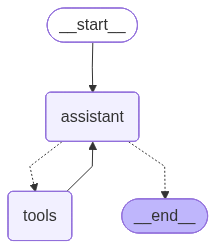

In [16]:
builder = StateGraph (MessagesState)
builder.add_node ('tools', ToolNode(tools))
builder.add_node ('assistant', assistant)

builder.add_edge (START, 'assistant')
builder.add_conditional_edges ('assistant', tools_condition)
builder.add_edge ('tools', 'assistant')

graph = builder.compile ()

display (Image( (graph.get_graph().draw_mermaid_png())))

In [18]:
query = "What is 6+5*7"
response = graph.invoke (input={'messages': [HumanMessage(content=query)]})

for m in response['messages']:
    m.pretty_print ()

================================ Human Message =================================

What is 6+5*7
================================== Ai Message ==================================
Tool Calls:
  add (call_qadVCmcUe0QwEoGiKjnYpJ2E)
 Call ID: call_qadVCmcUe0QwEoGiKjnYpJ2E
  Args:
    a: 6
    b: 35
  multiply (call_ztIoRH1ABSheWJADGZNoPplm)
 Call ID: call_ztIoRH1ABSheWJADGZNoPplm
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: add

41
================================= Tool Message =================================
Name: multiply

35
================================== Ai Message ==================================

The result of 6 + 5 * 7 is 41.


### Web search

pip install tavily

In [22]:
from tavily import TavilyClient

TavilySearch = TavilyClient (api_key=os.getenv ("TAVILY_API_KEY"))

In [28]:
searchResult = TavilySearch.search (query="Latest on Champions league",
                                    max_results=5,)

In [24]:
searchResult

{'query': 'latest Anambra state governorship election results',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.vanguardngr.com/2025/11/breaking-apgas-soludo-wins-anambra-governorship-election/',
   'title': "APGA's Soludo wins Anambra governorship election",
   'content': 'Chukwuma Soludo, candidate of the All Progressives Grand Alliance (APGA), has emerged the winner of the Anambra State governorship election.',
   'score': 0.81347597,
   'raw_content': None},
  {'url': 'https://www.instagram.com/reel/DQ0_F72iGfz/',
   'title': 'Soludo Declared Winner in Anambra State Governorship ...',
   'content': 'The highly anticipated Anambra state governorship election results have been announced, and Charles Chukwuma Soludo of the All Progressives',
   'score': 0.798077,
   'raw_content': None},
  {'url': 'https://www.facebook.com/Fortheloveofanambra/posts/anambra-governorship-resultfinal-result-as-all-the-21-lgas-are-inapga-422664apc-/141236806

In [29]:
searchResult['results']

[{'url': 'https://www.newsnow.co.uk/h/Sport/Football/UEFA+Champions+League',
  'title': 'UEFA Champions League News | Latest UCL Updates - NewsNow',
  'content': 'Latest Champions League news in a live news feed, including updates on UCL fixtures and results, qualifiers, draws, and the 24/25 Champions League final at the',
  'score': 0.7485182,
  'raw_content': None},
 {'url': 'https://www.uefa.com/uefachampionsleague/news/',
  'title': 'News | UEFA Champions League',
  'content': 'Follow all the latest UEFA Champions League 2025/2026 news from the official UEFA.com site. Includes latest news stories, videos, match reports and much',
  'score': 0.7077487,
  'raw_content': None},
 {'url': 'https://www.si.com/soccer/champions-league',
  'title': 'Latest Champions League News & Rumors - Sports Illustrated',
  'content': 'Stay updated with the latest Champions League news and rumors. Including match previews, lineups & player ratings.',
  'score': 0.6882385,
  'raw_content': None},
 {'url'

In [30]:
searchContent = ""

for result in searchResult['results']:
    content = f"""Source: {result['url']}
Content: {result['content']}\n\n"""
    searchContent += content

print (searchContent)

Source: https://www.newsnow.co.uk/h/Sport/Football/UEFA+Champions+League
Content: Latest Champions League news in a live news feed, including updates on UCL fixtures and results, qualifiers, draws, and the 24/25 Champions League final at the

Source: https://www.uefa.com/uefachampionsleague/news/
Content: Follow all the latest UEFA Champions League 2025/2026 news from the official UEFA.com site. Includes latest news stories, videos, match reports and much

Source: https://www.si.com/soccer/champions-league
Content: Stay updated with the latest Champions League news and rumors. Including match previews, lineups & player ratings.

Source: https://www.marca.com/en/football/champions-league.html
Content: Newcastle 1 - 2 Barcelona: Goals and highlights - Champions League 25/26 ... Kylian Mbappe. Real Madrid 2-1 Marseille. Mbappe scores two penalties as Real

Source: https://www.tntsports.co.uk/football/champions-league/
Content: Get updates on the latest Champions League action and find art

### ChatBot with realtime websearch

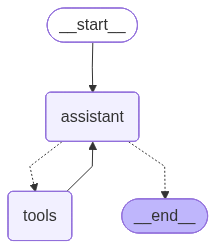

In [31]:
@tool
def searchTool (query:str) -> str:
    """
    Searches the web in real-time and returns the response.

    Args:
        query: String--A query to search in the web
    """
    searchResult = TavilySearch.search (query=query,
                                    max_results=5,)
    searchContent = ""

    for result in searchResult['results']:
        content = f"""Source: {result['url']}
    Content: {result['content']}\n\n"""
        searchContent += content

    return searchContent

tools = [searchTool]
llm_search = llm.bind_tools (tools=tools)

sys_prompt = """You are an intelligent assistant that can answer any question.
If you know the answer, respond directly.
If you do not know the answer, use your web search tool to find the information in real-time and respond accurately.
Always provide clear and helpful answers based on the information available."""

sys_msg = SystemMessage (content=sys_prompt)

def assistant (state:MessagesState) -> MessagesState:
    msg = state['messages']
    response = llm_search.invoke ([sys_msg] + msg)
    return {'messages': response}


builder = StateGraph (MessagesState)
builder.add_node ('tools', ToolNode(tools))
builder.add_node ('assistant', assistant)

builder.add_edge (START, 'assistant')
builder.add_conditional_edges ('assistant', tools_condition)
builder.add_edge ('tools', 'assistant')

graph = builder.compile ()

display (Image( (graph.get_graph().draw_mermaid_png())))

In [32]:
query = "Who are youS"
msg = HumanMessage (content= query)

response = graph.invoke (input={'messages': [msg]})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Who are youS
================================== Ai Message ==================================

I am an intelligent assistant designed to answer questions and provide information. How can I help you today?


In [35]:
query = "Who won the Anambra 2025 election and wih which margin"
msg = HumanMessage (content= query)

response = graph.invoke (input={'messages': [msg]})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Who won the Anambra 2025 election and wih which margin
================================== Ai Message ==================================
Tool Calls:
  searchTool (call_BlVrumFjhxSUETaEX4wvbArQ)
 Call ID: call_BlVrumFjhxSUETaEX4wvbArQ
  Args:
    query: Anambra 2025 election winner and margin of victory
================================= Tool Message =================================
Name: searchTool

Source: https://x.com/i/trending/1987447865531080719
    Content: Governor Charles Soludo of the All Progressives Grand Alliance won re-election in Anambra State on November 8, 2025, with 422664 votes,

Source: https://www.facebook.com/channelsforum/posts/apgas-soludo-charles-chukwuma-was-declared-the-winner-of-the-2025-anambra-state-/1487898209364592/
    Content: APGA's Soludo Charles Chukwuma was declared the winner of the 2025 Anambra State governorship election with a total of 422664 votes,

Source: https: